<a href="https://colab.research.google.com/github/nivalf/Predict_Energy_Usage/blob/main/predict_energy_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predict Energy Usage



A dataset with information on weather in an area and the energy use of a residential building is given.
The data set comprises the timestamp the data were taken, the amount of energy used by various
home appliances and rooms, the amount of energy produced by a solar panel that was installed, *and*
various weather conditions including cloud cover, wind speed, precipitation, etc. The dataset has a
total of 30 features. This assignment’s goal is to create multiple machine learning models to
predict how much energy will be consumed and assess the effectiveness of each model using various
matrices.

##Domain Analysis


The household electric energy consumption is highly correlated to air temperature, moderately correlated to precipitation and duration of sunshine [1].

When the daily temperature rises, the daily electricity demand falls [2]. The decline in demand as the temperature rises could be attributed to a number of factors, including an increase in outside activity and a decrease in the need for heating [1]. However, it is interesting to note that this pattern isn’t essentially true from late night hours to early morning time. This is because the people would be resting during this time. The electricity usage shows high sensitivity to temperature during the day time and early night time [1].

Given that individuals are less inclined to go outside when it rains more heavily, more rainfall may be related to higher electricity demand. As in the case of temperature, rain doesn’t have much effect on the energy consumption during late nights and early mornings for the same reasons [1].

People tend to engage in more outdoor activities during sunny days leading to a reduction in the household energy consumption. However a clear pattern is observed before and after the time 15:00. It can be explained as more indoor activities might take place from morning to around 15:00 and later people get engaged in outdoor activities [1] [3] [4].

The daytime till late-night demand for power is increased by relative humidity and wind speed. This pattern is similar to that of temperature. However, all the effects of humidity and wind speed are relatively insignificant [1].

The energy consumption during weekends follow a different pattern than weekdays. This could be because people spend more time at house rather than office during weekends and the activities during weekend vary considerably from that of weekdays [1]. 

Thus, temperature, precipitation and duration of sunshine are major factors for deciding energy consumption whereas humidity and wind speed has very small influence [1]. However, the humidity and wind speed can be combined with temperature to get apparent temperature which is the perceived temperature in degrees Fahrenheit for the specified hour determined by either a combination of temperature and wind (Wind Chill) or by a combination of temperature and humidity (Heat Index). The wind chill factor will be applied to a grid point’s apparent temperature when the outside temperature drops to 50 F or less at that location. The heat index will be utilised for Apparent Temperature whenever a grid point’s temperature exceeds 80 F. The ambient air temperature is represented as the
apparent temperature between 51 and 80 F [5].

A solar panel attached to a house can generate a fair amount of energy at suitable environmental conditions. Even while solar energy can still be captured on cloudy and rainy days, the solar panel’s energy generation effectiveness is reduced. Sunlight is necessary for solar panels to efficiently collect solar energy. As a result, a few days of cloudy, rainy weather can significantly affect the energy grid. Furthermore, higher temperature doesn’t necessarily mean higher energy generation. Solar panels
have ambient working temperature which is dependent on its manufacture [6].


####References


[1] J. Kang and D. M. Reiner, “What is the effect of weather on household electricity consumption?
Empirical evidence from Ireland,” Energy Economics, vol. 111, p. 106023, 2022.

[2] L. Bl ́azquez, N. Boogen, and M. Filippini, “Residential electricity demand in spain: New empirical
evidence using aggregate data,” Energy Economics, vol. 36, p. 648–657, 2013.

[3] J. Harold, S. Lyons, and J. Cullinan, “The determinants of residential gas demand in ireland,”
Energy Economics, vol. 51, p. 475–483, 2015.

[4] V. D. Cosmo and D. O’Hora, “Nudging electricity consumption using TOU pricing and feedback:
Evidence from Irish households,” Journal of Economic Psychology, vol. 61, p. 1–14, 2017.

[5] "What is apparent temperature?". [Online]. Available: https://meteor.geol.iastate.edu/~ckarsten/bufkit/apparent_temperature.html

[6] “How does the weather affect your solar panels?” Feb 2020. [Online]. Available:
https://www.penrithsolar.com.au/blog/how-does-the-weather-affect-your-solar-panels



# 1. Import Libraries & Load Data

## Setup & Imports

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler # for standardizing the Data

# Common imports
import numpy as np
import os
import pandas as pd
pd.set_option("display.max_columns", None)
from datetime import datetime

# To plot pretty figures
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "predict_diamond_price"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load the Data

In [2]:
def load_energy_usage_data():
    return pd.read_csv('https://raw.githubusercontent.com/nivalf/Predict_Energy_Usage/main/data/dataset.csv')

In [3]:
energy_usage = load_energy_usage_data()
# Copy for doing analysis
energy_usage_ = energy_usage.copy(deep=True)

<ipython-input-3-a7b0b94ecf3a>:1: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  energy_usage = load_energy_usage_data()


# 2. Pre-Processing & Feature Engineering

## Clean the Data


The error observed after loading the data indicates mixed values in Column 0. 

In [4]:
energy_usage_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50392 entries, 0 to 50391
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 50392 non-null  object 
 1   use [kW]             50391 non-null  float64
 2   gen [kW]             50391 non-null  float64
 3   House overall [kW]   50391 non-null  float64
 4   Dishwasher [kW]      50391 non-null  float64
 5   Furnace 1 [kW]       50391 non-null  float64
 6   Furnace 2 [kW]       50391 non-null  float64
 7   Home office [kW]     50391 non-null  float64
 8   Fridge [kW]          50391 non-null  float64
 9   Wine cellar [kW]     50391 non-null  float64
 10  Garage door [kW]     50391 non-null  float64
 11  Kitchen 12 [kW]      50391 non-null  float64
 12  Kitchen 14 [kW]      50391 non-null  float64
 13  Kitchen 38 [kW]      50391 non-null  float64
 14  Barn [kW]            50391 non-null  float64
 15  Well [kW]            50391 non-null 

From the dataframe info, it can be seen that columns 1-29 has one null value.

Identifying row with NaN values:

In [5]:
def clean_rows_with_null_values(df):
  rows_with_null = df[df.isna().any(axis=1)]
  print("Droping rows with null values")

  # drop the rows
  return df.drop(rows_with_null.index, inplace=False)

Row number 50391, which is the last row in the dataframe contains invalid data for all the columns. Thus, imputing this row.

In [6]:
energy_usage_ = clean_rows_with_null_values(energy_usage_)

Droping rows with null values


##Pre Processing

#### Pre Process: Convert UNIX timestamp

Convert the UNIX timestamp to date and time. The publisher of the dataset has mentioned that the timestamp corresponds to minutes and not seconds (was a scripting error). Thus using the sample frequency as minutes. Also, making this as the index of the dataframe.

In [7]:
# Convert Unix timestamp to datetime
# index*590 is the correction factor to convert the timestamp with frequency of minutes 
def convert_unix_ts_to_timestamp(df_):
  df = df_.copy(deep=True)

  if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'].astype('int64') + df.index*590, unit='s')
    print('UNIX time stamp converted to normal date and time')
  else:
    print('Skipping conversion to timestamp')
  
  return df

In [8]:
# set the 'time' column as index of the df
def set_time_as_index(df_):
  df = df_.copy(deep=True)

  if 'time' in df.columns:
    df = df.set_index('time')
    print('time column set as index of the dataframe')
  else:
    print('Skipping setting index')

  return df

In [9]:
energy_usage_ = convert_unix_ts_to_timestamp(energy_usage_)
energy_usage_ = set_time_as_index(energy_usage_)

energy_usage_.head(1)

UNIX time stamp converted to normal date and time
time column set as index of the dataframe


,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,Weather icon,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.0207,0.061917,0.442633,0.12415,0.006983,0.013083,0.000417,0.00015,0.0,0.03135,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0


###Correlations

#### Energy Correlations

In [10]:
energy_usage_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50391 entries, 2016-01-01 05:00:00 to 2016-12-16 03:20:00
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   use [kW]             50391 non-null  float64
 1   gen [kW]             50391 non-null  float64
 2   House overall [kW]   50391 non-null  float64
 3   Dishwasher [kW]      50391 non-null  float64
 4   Furnace 1 [kW]       50391 non-null  float64
 5   Furnace 2 [kW]       50391 non-null  float64
 6   Home office [kW]     50391 non-null  float64
 7   Fridge [kW]          50391 non-null  float64
 8   Wine cellar [kW]     50391 non-null  float64
 9   Garage door [kW]     50391 non-null  float64
 10  Kitchen 12 [kW]      50391 non-null  float64
 11  Kitchen 14 [kW]      50391 non-null  float64
 12  Kitchen 38 [kW]      50391 non-null  float64
 13  Barn [kW]            50391 non-null  float64
 14  Well [kW]            50391 non-null  float64
 15  M

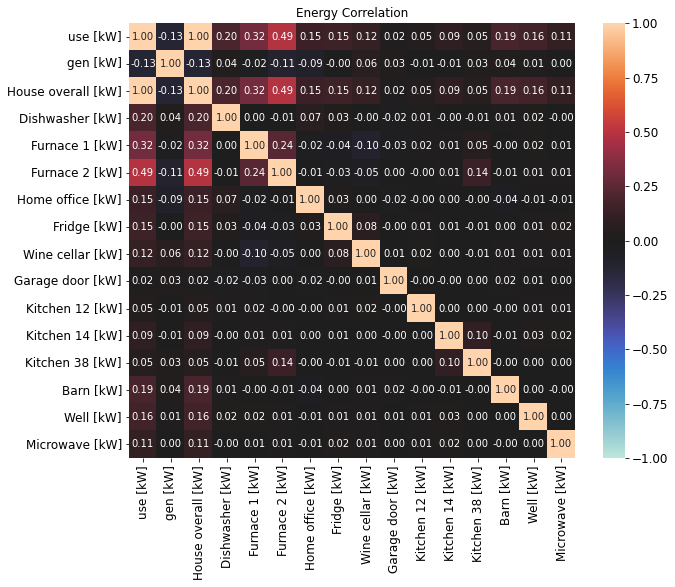

In [11]:
fig = plt.subplots(figsize=(10, 8))
sns.heatmap(energy_usage_[energy_usage_.columns[:16].tolist()].corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, center=0)
plt.title('Energy Correlation', fontsize=12);

Energy consumption (use [kW]) has the highest correlation to Furnace 2 (0.49), followed by Furnace 1 (0.32), Dishwasher (0.20), Living Room (0.20), Barn (0.19), Well (0.16), Home office (0.15), Fridge (0.15), Wine Cellar (0.12) and Microwave (0.11). 

#### Pre Process: Remove duplicate columns

Use [kW] and House overall [kW] have complete correlation. Same is the case for gen [kW] and Solar [kW]. So check if these are the same values.

In [12]:
print(energy_usage_['gen [kW]'].equals(energy_usage_['Solar [kW]']))
print(energy_usage_['use [kW]'].equals(energy_usage_['House overall [kW]']))

True
True


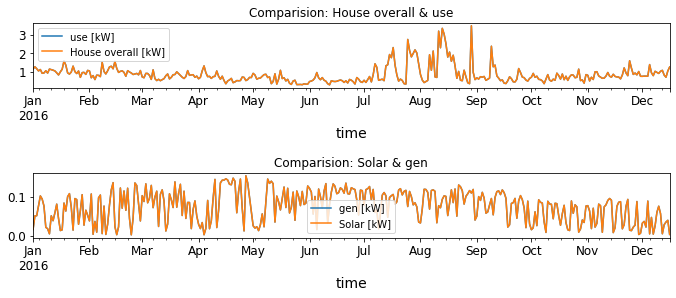

In [13]:
fig, axes = plt.subplots(2,1, figsize=(11,5))
# using padding
fig.tight_layout(pad=6.0)
energy_usage_[['use [kW]','House overall [kW]']].resample('D').mean().plot(ax=axes[0], title="Comparision: House overall & use")
energy_usage_[['gen [kW]','Solar [kW]']].resample('D').mean().plot(ax=axes[1], title="Comparision: Solar & gen")

The columns (use [kW], House overall [kW]) and (gen [kW], Solar [kW]) are duplicates. One of each can be dropped.

In [14]:
def remove_use_and_gen_columns(df_):
  df = df_.copy(deep=True)

  if 'use [kW]' in df:
    df.drop(['use [kW]', 'gen [kW]'], axis=1, inplace=True)
    print('Dropped "use [kW]" and "gen [kW] ')
  else:
    print("Skipping drop use and gen columns")

  return df

In [15]:
energy_usage_ = remove_use_and_gen_columns(energy_usage_)
energy_usage_.head(1)

Dropped "use [kW]" and "gen [kW] 


,House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,Weather icon,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,0.932833,0.000033,0.0207,0.061917,0.442633,0.12415,0.006983,0.013083,0.000417,0.00015,0.0,0.03135,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0


#### Weather Correlations

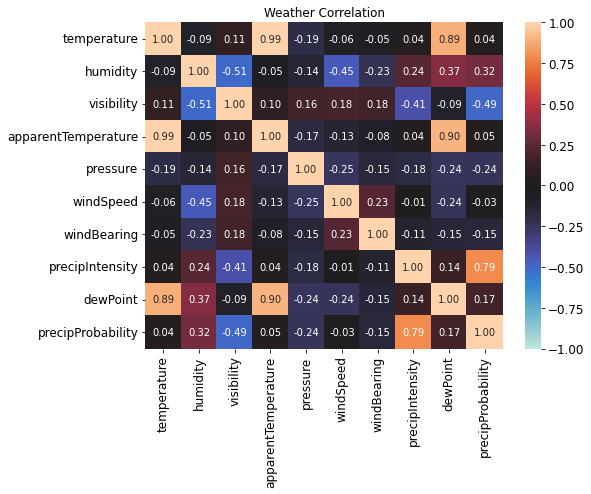

In [16]:
fig = plt.subplots(figsize=(8, 6))
sns.heatmap(energy_usage_[energy_usage_.columns[16:].tolist()].corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, center=0)
plt.title('Weather Correlation', fontsize=12);

Among the weather features, apparentTemperature is highly correlated to temperature (0.99) and dewPoint (0.90), while precipIntensity is correlated to precipProbability (0.79). Visibility has negative correlation with humidity (-0.51), precipProbability (-0.49) and precipIntensity (-0.41). Humidity also has negative correlation with windspeed (-0.45) and positive correlations with dewPoint (0.37), precipProbability (0.32) and precipIntensity (0.24).

#### Total Correlations

In [17]:
energy_usage_.corr()

,House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
House overall [kW],1.000000,0.195984,0.316722,0.489519,0.146279,0.151083,0.124921,0.015477,0.046659,0.094252,0.047615,0.187581,0.164139,0.113790,0.202683,-0.132511,0.007779,0.012684,-0.003037,0.003011,0.009513,-0.004942,0.013879,0.020766,0.014061,-0.005721
Dishwasher [kW],0.195984,1.000000,0.000468,-0.010315,0.066702,0.034390,-0.004108,-0.016788,0.008721,-0.000842,-0.011645,0.010485,0.016094,-0.000187,0.001046,0.035874,-0.017903,-0.001996,-0.008340,-0.016748,0.001012,-0.001935,0.004680,0.005059,-0.018244,0.007240
Furnace 1 [kW],0.316722,0.000468,1.000000,0.240180,-0.019539,-0.042416,-0.100324,-0.027651,0.015364,0.010182,0.047000,-0.002384,0.022029,0.006780,0.067619,-0.020905,-0.302930,-0.049550,-0.037243,-0.309590,-0.000992,0.089347,0.026364,0.008317,-0.302403,-0.001665
Furnace 2 [kW],0.489519,-0.010315,0.240180,1.000000,-0.010326,-0.029313,-0.051870,0.000339,-0.001012,0.009122,0.144528,-0.008989,0.010624,0.011838,0.031269,-0.106520,-0.236148,-0.038135,-0.012931,-0.243120,-0.002132,0.072643,0.032151,0.021838,-0.234509,0.007872
Home office [kW],0.146279,0.066702,-0.019539,-0.010326,1.000000,0.033419,0.004340,-0.016144,-0.004875,0.002087,-0.002017,-0.039481,-0.006527,-0.010861,-0.052252,-0.085009,0.012246,-0.006132,0.020494,0.011192,0.026202,-0.017754,0.013699,-0.029898,0.007742,-0.033048
Fridge [kW],0.151083,0.034390,-0.042416,-0.029313,0.033419,1.000000,0.075198,-0.000128,0.010444,0.007675,-0.012898,0.000634,0.009865,0.023452,0.053926,-0.004756,0.103866,0.032351,0.006144,0.103522,-0.001207,-0.023907,-0.008170,0.015161,0.112513,0.005350
Wine cellar [kW],0.124921,-0.004108,-0.100324,-0.051870,0.004340,0.075198,1.000000,0.007401,0.019335,0.001235,-0.010927,0.012464,0.008301,0.008608,0.034085,0.062916,0.290064,0.054309,0.030500,0.289682,0.018038,-0.052410,-0.025245,0.017257,0.298522,0.007224
Garage door [kW],0.015477,-0.016788,-0.027651,0.000339,-0.016144,-0.000128,0.007401,1.000000,-0.002105,-0.002317,0.003365,0.015397,0.006348,0.000232,0.006006,0.033660,0.011548,-0.005776,0.004604,0.011711,-0.000618,0.001492,0.015297,-0.009575,0.007619,-0.010691
Kitchen 12 [kW],0.046659,0.008721,0.015364,-0.001012,-0.004875,0.010444,0.019335,-0.002105,1.000000,0.002467,0.002441,-0.004270,0.010934,0.011637,0.044022,-0.013667,-0.005250,0.030076,-0.007847,-0.000958,0.012492,-0.038097,-0.000340,-0.014749,0.007691,-0.019840
Kitchen 14 [kW],0.094252,-0.000842,0.010182,0.009122,0.002087,0.007675,0.001235,-0.002317,0.002467,1.000000,0.101564,-0.009040,0.027274,0.018276,0.112338,-0.013608,-0.010161,-0.000064,0.001813,-0.009918,-0.001975,0.000239,0.003523,-0.006241,-0.009516,-0.004837


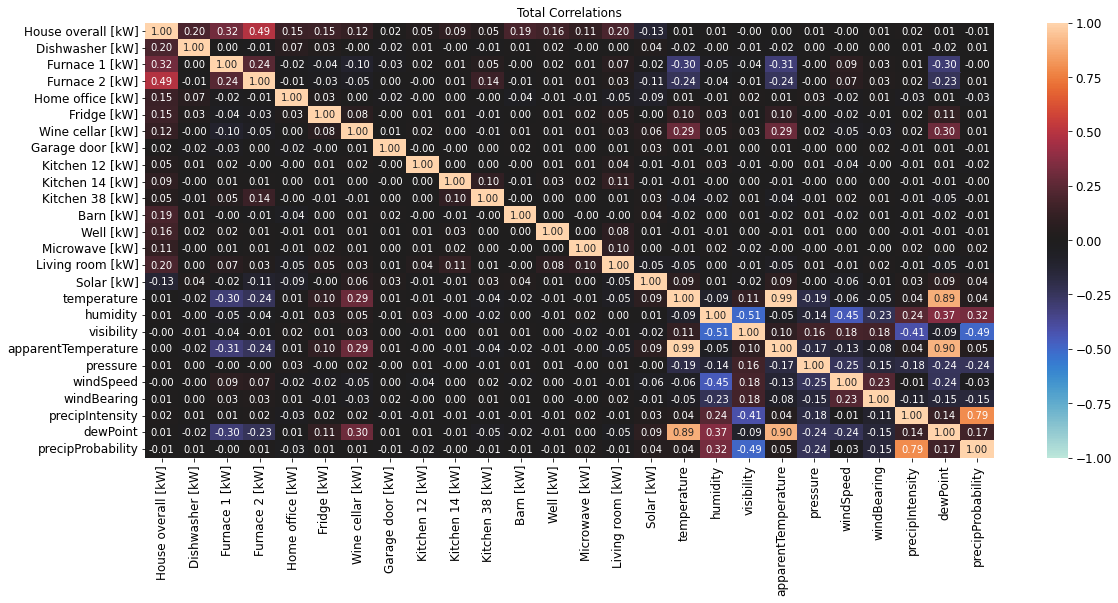

In [18]:
fig = plt.subplots(figsize=(19, 8))
sns.heatmap(energy_usage_[energy_usage_.columns.tolist()].corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, center=0)
plt.title('Total Correlations', fontsize=12);



Temperature, apparentTemperature and dewPoint have high negative correlation (~ -0.30) to the Furnaces which in turn has high positive correlation to energy usage. Furthermore, these three features have high positive correlation to Wine Cellar (\~0.30) and Fridge (~0.10).



### Visualise Data

#### Energy Usage

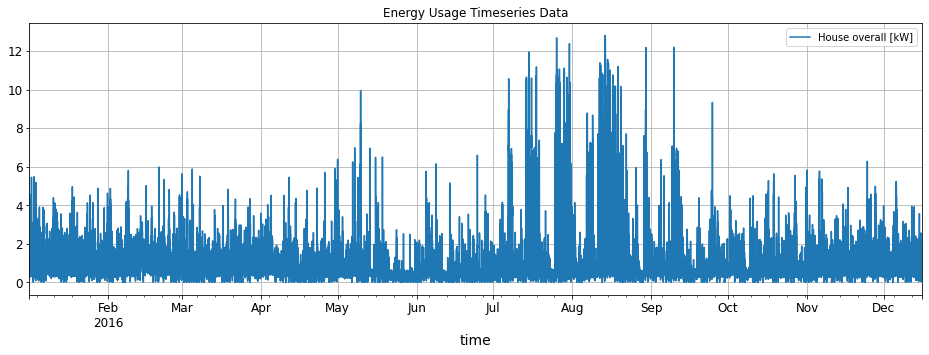

In [19]:
energy_usage_[energy_usage_.columns[0:1].tolist()].plot(grid=True, figsize=(16, 5), title="Energy Usage Timeseries Data");

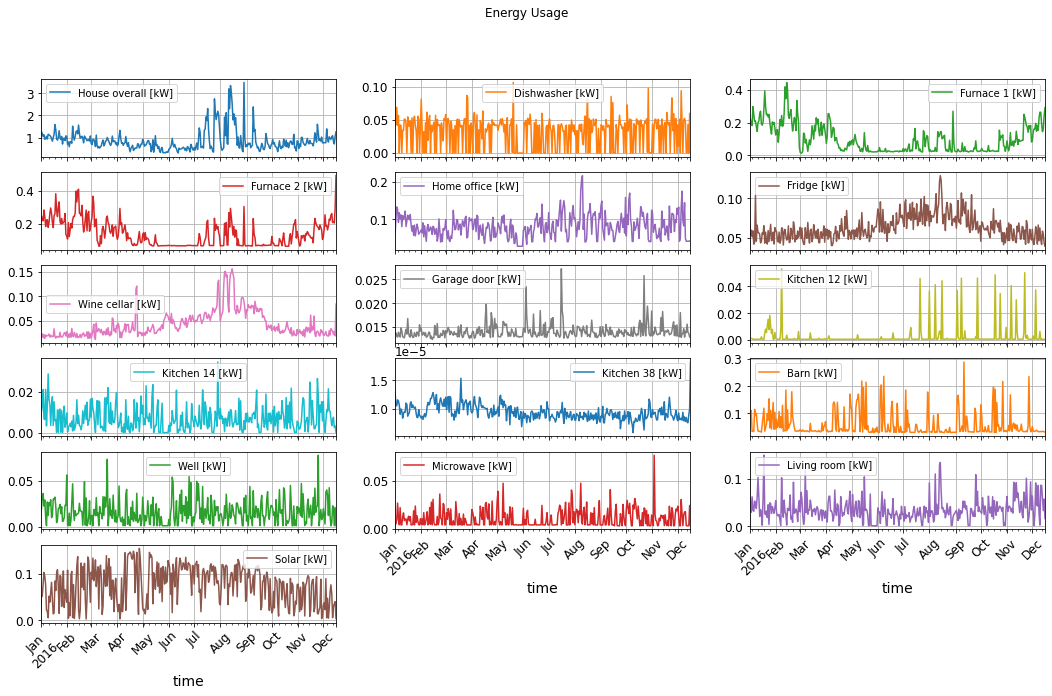

In [20]:
energy_usage_[energy_usage_.columns[0:16].tolist()].resample("D").mean().plot(subplots=True, layout=(-1, 3), figsize=(18, 10),
                                                                grid=True, rot=45, title="Energy Usage");

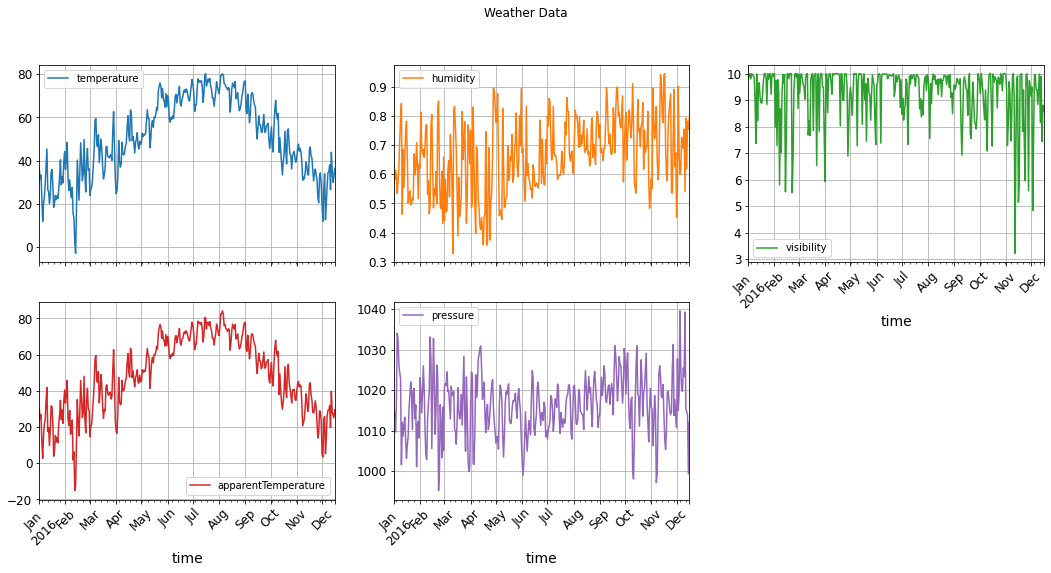

In [21]:
energy_usage_[energy_usage_.columns[16:-5].tolist()].resample("D").mean().plot(subplots=True, layout=(-1, 3), figsize=(18, 8),
                                                                grid=True, rot=45, title="Weather Data");

#### Pre Process: Add new features for month, day, weekday, hour and minute

Define month, day, weekday, hour & minute from date time.

In [22]:
def add_expanded_ts_features(df_):
  df = df_.copy(deep=True)
  df['month'] = df.index.month
  df['day'] = df.index.day
  df['weekday'] = df.index.day_name()
  df['hour'] = df.index.hour
  df['minute'] = df.index.minute

  print('month, day, weekday, hour and minute features added using timestamp data')
  
  return df

In [23]:
energy_usage_ = add_expanded_ts_features(energy_usage_)
energy_usage_.head(1)

month, day, weekday, hour and minute features added using timestamp data


,House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,Weather icon,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability,month,day,weekday,hour,minute
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,0.932833,0.000033,0.0207,0.061917,0.442633,0.12415,0.006983,0.013083,0.000417,0.00015,0.0,0.03135,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1,1,Friday,5,0


#### Average Consumptions

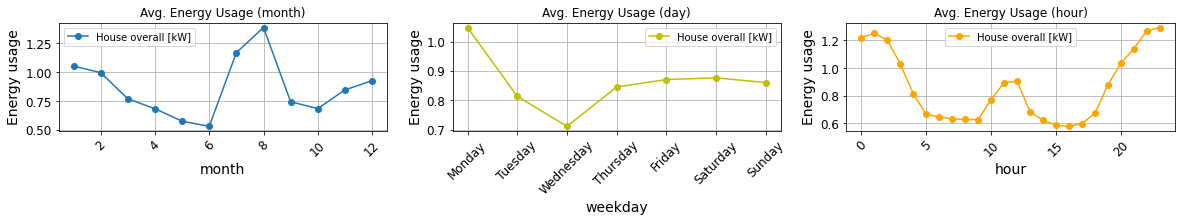

In [24]:
# Weather icon is 'object' type which is text field. Here the mean numeric values are going to be used.
# Thus dropping 'Weather icon'
energy_usage__avg = energy_usage_.drop('Weather icon', axis=1)

fig, axes = plt.subplots(1,3, figsize=(20,2))

mean_month = energy_usage__avg.groupby('month').agg({i:'mean' for i in energy_usage__avg.columns[:1].tolist()})
mean_month[mean_month.columns[0:1].tolist()].plot( grid=True, rot=45, xlabel=None, ylabel="Energy usage", marker='o', 
                                                  title="Avg. Energy Usage (month)", ax=axes[0]);

days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_weekday = energy_usage__avg.groupby('weekday').agg({i:'mean' for i in energy_usage__avg.columns[:1].tolist()}).reindex(days)
mean_weekday[mean_weekday.columns[0:1].tolist()].plot( color='y',  grid=True, rot=45, xlabel=None, ylabel="Energy usage", marker='o', 
                                                      title="Avg. Energy Usage (day)", ax=axes[1]);

mean_hour = energy_usage__avg.groupby('hour').agg({i:'mean' for i in energy_usage__avg.columns[:1].tolist()})
mean_hour[mean_hour.columns[0:1].tolist()].plot( color='orange', grid=True, rot=45, xlabel=None, ylabel="Energy usage", marker='o', 
                                                title="Avg. Energy Usage (hour)", ax=axes[2]);

The energy usage decreases from January to June where it is the least. It then increases rapidly to peak during the month of August and falls rapidly during September and then gradually increase from October to December.

It can be seen that Monda has the highest energy consumption while the lowest is on Wednesday. The usage of other days remain fairly constant. Furthermore, the consumption is relatively high during 20:00 to 3:00.

#### Monthly Average

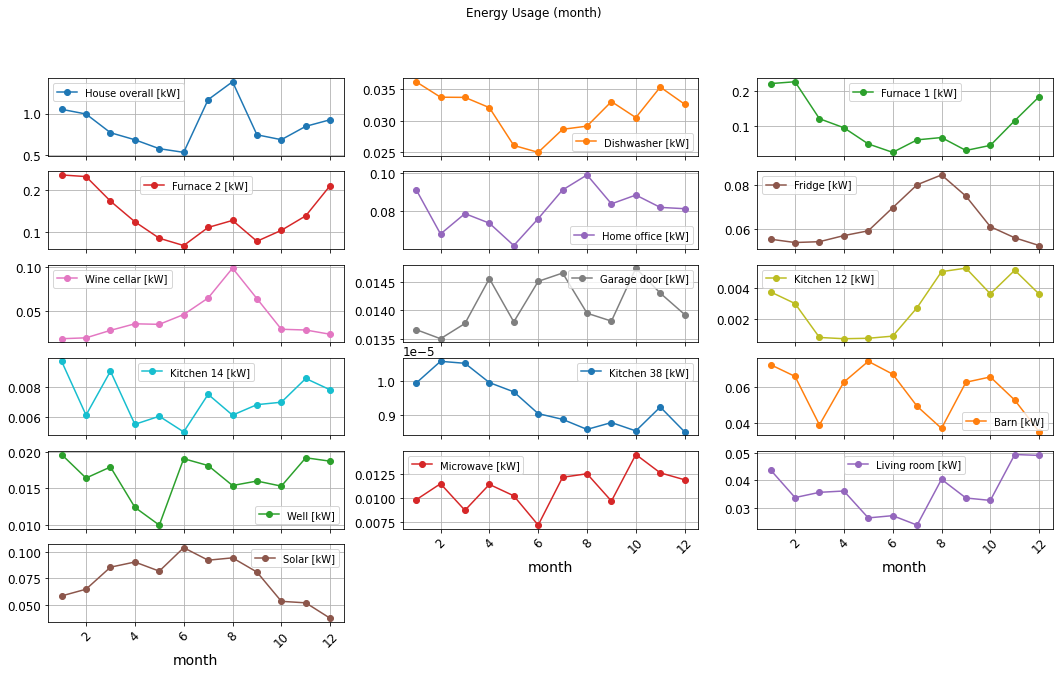

In [25]:
mean_month = energy_usage__avg.groupby('month').agg({i:'mean' for i in energy_usage__avg.columns[:-5].tolist()})
mean_month[mean_month.columns[0:16].tolist()].plot(subplots=True, layout=(-1, 3), figsize=(18, 10),
                                                       grid=True, rot=45, xlabel=None, marker='o', title="Energy Usage (month)");

#### Daily Average

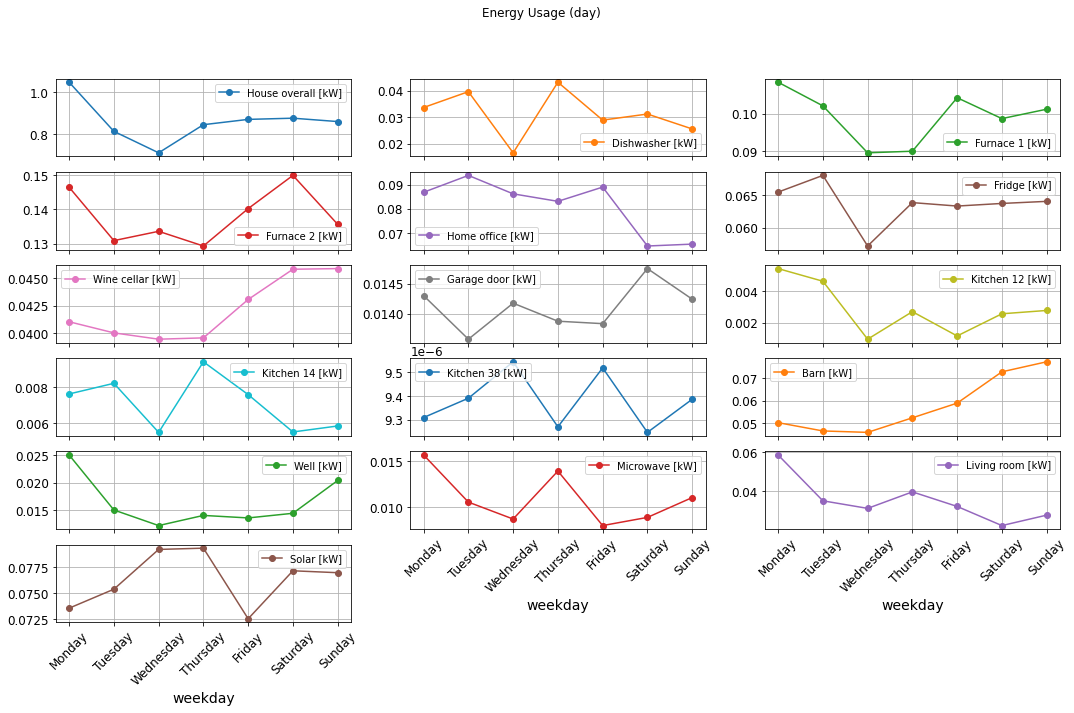

In [26]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_weekday = energy_usage__avg.groupby('weekday').agg({i:'mean' for i in energy_usage__avg.columns[:-5].tolist()}).reindex(days)

mean_weekday[mean_weekday.columns[0:16].tolist()].plot(subplots=True, layout=(-1, 3), figsize=(18, 10),
                                                       grid=True, rot=45, xlabel=None, marker='o', title="Energy Usage (day)");

#### Hourly Average

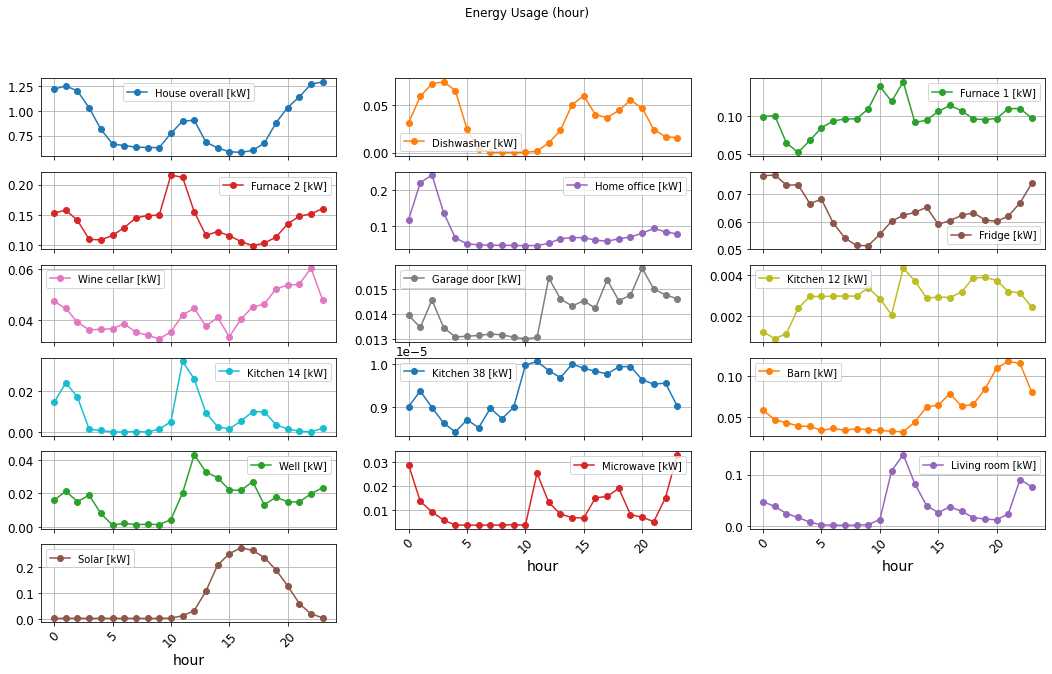

In [27]:
mean_hour = energy_usage__avg.groupby('hour').agg({i:'mean' for i in energy_usage__avg.columns[:-5].tolist()})

mean_hour[mean_hour.columns[0:16].tolist()].plot(subplots=True, layout=(-1, 3), figsize=(18, 10),
                                                       grid=True, rot=45, xlabel=None, marker='o', title="Energy Usage (hour)");

## Dimension Reduction

### Principal Component Analysis (PCA)

#### Prepare the dataframe

Create a new dataframe from the energy_usage_ dataframe.

In [28]:
weather_data = energy_usage_[energy_usage_.columns[16:].tolist()].copy(deep=True)

The 'Weather icon' feature is a categorical feature. To do PCA, numerical encoding is done to this feature.


In [29]:
weather_data['Weather icon'].unique()

array(['clear-night', 'partly-cloudy-night', 'clear-day', 'cloudy',
       'partly-cloudy-day', 'rain', 'snow', 'wind', 'fog'], dtype=object)

In [30]:
weather_data['Weather icon'].replace(['clear-night', 'partly-cloudy-night', 'clear-day', 'cloudy',
       'partly-cloudy-day', 'rain', 'snow', 'wind', 'fog'], [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=True)

Similarly, weekday column has text values. This can be dropped.

In [31]:
weather_data.drop('weekday', axis=1, inplace=True)

Standardise the data.

In [32]:
sc = StandardScaler() # creating a StandardScaler object
x = sc.fit_transform(weather_data) # standardizing the data
weather_data = pd.DataFrame(x, columns=weather_data.columns, index=weather_data.index)

Hence the prepared dataframe for PCA:


In [33]:
weather_data.head(1)

,temperature,Weather icon,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability,month,day,hour,minute
time,,,,,,,,,,,,,,,
2016-01-01 05:00:00,-0.763918,-0.972995,-0.22666,0.463501,-0.862651,0.077045,0.635668,0.747213,-0.230541,-0.748817,-0.340542,-1.587338,-1.639754,-0.939236,-1.463798


#### PCA

In [34]:
from sklearn.decomposition import PCA # for PCA calculation

pcamodel = PCA(n_components=0.98)
pca = pcamodel.fit_transform(x)
pca.shape

(50391, 12)

10 principal components are required to retain 93% of the data.

12 components required to retain 98% of the data.

| PCA Components | Percentage Information |
|----------------|------------------------|
| 10             | 91.1% - 93%            |
| 11             | 93.1% - 96%            |
| 12             | 96.1% - 98%            |
| 13             | 98.1% - 99.999%        |




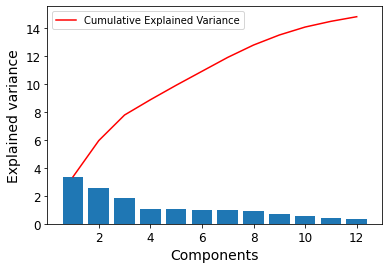

In [35]:
plt.bar(range(1,len(pcamodel.explained_variance_ )+1),pcamodel.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pcamodel.explained_variance_ )+1),
         np.cumsum(pcamodel.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

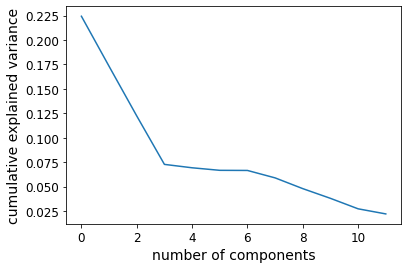

In [36]:
plt.plot(pcamodel.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#PCA1 is at 0 in xscale

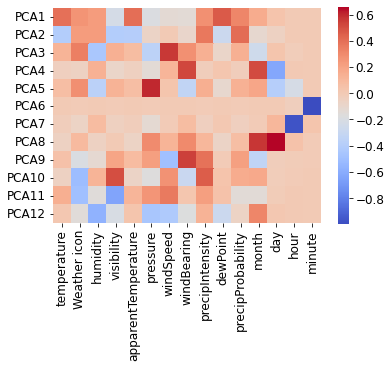

In [37]:
ax = sns.heatmap(pcamodel.components_,
                 cmap='coolwarm',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(weather_data.columns),
                 cbar_kws={"orientation": "vertical"})
ax.set_aspect("equal")

The heatmap shows the dependency of each weather feature to the principal components. 

Filtering out the features which have highest effect on the PCA:

In [38]:
pca_values = pd.DataFrame(pcamodel.components_, columns = weather_data.columns)
pca_values = pca_values[(pca_values > 0.4) | (pca_values < -0.6) ]
pca_values.dropna(axis=1, how='all', inplace=True)
pca_values.dropna(how='all', inplace=True)
features = pca_values.max(axis=0)
features.sort_values(ascending=False)

day                    0.660052
pressure               0.605089
month                  0.571204
windSpeed              0.564532
windBearing            0.546540
visibility             0.504834
dewPoint               0.469239
precipIntensity        0.460775
precipProbability      0.411707
apparentTemperature    0.404967
hour                  -0.973440
minute                -0.999438
dtype: float64

Thus, minute, hour, day, pressure, month, windSpeed, windBearing and visibility are the prominent features in the order of decreasing importance.

# Prediction Models


## Split Feature and Label

In [123]:
# Load the data
energy_usage = load_energy_usage_data()
energy_usage = clean_rows_with_null_values(energy_usage)

Droping rows with null values


<ipython-input-123-5137bf502929>:2: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  energy_usage = load_energy_usage_data()


Split the data into featues and label

In [124]:
X = energy_usage.drop('use [kW]', axis=1)
y = energy_usage['use [kW]']

## DEV TEST: Pre-processing

DEV TEST: All preprocessing functions together. 

In [41]:
# Do all pre-processing
def pre_process(df_, featureCount):
  print('Pre Processing the data')
  print('************ ****** **********')
  df = df_.copy(True)
  df = clean_rows_with_null_values(df)
  df = convert_unix_ts_to_timestamp(df)
  df = set_time_as_index(df)
  
  print('\nFeature Engineering')
  print('************ ****** **********')
  df = remove_use_and_gen_columns(df)
  df = add_expanded_ts_features(df)
  df = select_columns(df, featureCount)
  df = standardise(df)

  print('\n Standradising the data')
  return df

def select_columns(df_, featureCount):
  # 12 prominent weather features are listed in decreasing order of
  # importance. Select the required features from the beginning of the list.
  prominent_weather_features = ['minute', 'hour', 'day', 'pressure', 'month',
  'windSpeed', 'windBearing', 'visibility', 'dewPoint', 'precipIntensity',
  'precipProbability', 'apparentTemperature']
  
  df = df_.copy(deep=True)

  if featureCount > 12:
    print('ERROR: Feature count greater than available prominent feature count.')
    return df

  cols = prominent_weather_features[:featureCount]
  df = df[cols]
  print('Selected ', featureCount, ' columns: ', cols)
  return df

def standardise(df_):
  sc = StandardScaler() # creating a StandardScaler object
  x = sc.fit_transform(df_) # standardizing the data
  df = pd.DataFrame(x, columns=df_.columns, index=df_.index)
  print('Data Standardised')
  display(df)

In [42]:
X_ = pre_process(X,12)
X_

Pre Processing the data
************ ****** **********
Droping rows with null values
UNIX time stamp converted to normal date and time
time column set as index of the dataframe

Feature Engineering
************ ****** **********
Skipping drop use and gen columns
month, day, weekday, hour and minute features added using timestamp data
Selected  12  columns:  ['minute', 'hour', 'day', 'pressure', 'month', 'windSpeed', 'windBearing', 'visibility', 'dewPoint', 'precipIntensity', 'precipProbability', 'apparentTemperature']
Data Standardised


,minute,hour,day,pressure,month,windSpeed,windBearing,visibility,dewPoint,precipIntensity,precipProbability,apparentTemperature
time,,,,,,,,,,,,
2016-01-01 05:00:00,-1.463798,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541,-0.340542,-0.862651
2016-01-01 05:10:00,-0.878258,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541,-0.340542,-0.862651
2016-01-01 05:20:00,-0.292718,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541,-0.340542,-0.862651
2016-01-01 05:30:00,0.292822,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541,-0.340542,-0.862651
2016-01-01 05:40:00,0.878362,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541,-0.340542,-0.862651
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-16 02:40:00,0.878362,-1.372636,0.066939,-0.609460,1.726909,0.017918,-0.153833,-0.318302,-0.388896,0.665129,2.734026,-0.854026
2016-12-16 02:50:00,1.463902,-1.372636,0.066939,-0.609460,1.726909,0.017918,-0.153833,-0.318302,-0.388896,0.665129,2.734026,-0.854026
2016-12-16 03:00:00,-1.463798,-1.228169,0.066939,-0.609460,1.726909,0.017918,-0.153833,-0.318302,-0.388896,0.665129,2.734026,-0.854026



 Standradising the data


## Cross Validation: TimeSeriesSplit

Since the data belongs to a time series, random selection of data for cross validation discards any correlation to previous step. Thus a time series split, which is a form of K-Fold cross validation incorporating Forward Chaining Strategy is used. In this method, the kth split will contain first k folds as train set and the (k+1)th fold as test set.

Since the dataset has data from 1 Jan 2016 to 16 Dec 2016, the data is split into 11 with a gap of 288 data (2 days) between the train and test splits.

In [43]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=12,
    gap=288,    # Gap of 2 days
    # max_train_size=10000,
    # test_size=1000,
)

The size of the folds are as follows:

In [44]:
def printSplitSize():
  all_splits = list(ts_cv.split(X, y))

  split_data = []

  for index, split in enumerate(all_splits):
    split_data.append([index+1, split[0].shape[0], split[1].shape[0]])

  split_data = pd.DataFrame(split_data, columns=["Fold", 'Train_size', 'Test_size'])
  split_data = split_data.set_index('Fold')
  display(split_data)

printSplitSize()

,Train_size,Test_size
Fold,,
1,3591,3876
2,7467,3876
3,11343,3876
4,15219,3876
5,19095,3876
6,22971,3876
7,26847,3876
8,30723,3876
9,34599,3876


## Pipeline Construction

#### Pre-Processor Transform Function




1.   Convert the UNIX timestamp to normal timestamp



In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
x_ix, y_ix, z_ix = 0, 1, 2

class PreProcess(BaseEstimator, TransformerMixin):
    def __init__(self, columns): # no *args or **kargs
      self.columns = columns
    def fit(self, X, y=None):
      return self  # nothing else to do
    def transform(self, X):
      return self.pre_process(X)

    def pre_process(self,X):
      # print("\n************ Pre Processing ************")
      df = pd.DataFrame(X, columns = self.columns)
      df = self.convert_unix_ts_to_timestamp(df)
      return df.values

    # Convert Unix timestamp to datetime
    # index*590 is the correction factor to convert the timestamp with frequency of minutes 
    def convert_unix_ts_to_timestamp(self, df_):
      df = df_.copy(deep=True)

      if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'].astype('int64') + df.index*590, unit='s')
        # print('UNIX time stamp converted to normal date and time')
      # else:
        # print('time column not found. Skipping conversion to timestamp')
      
      return df

#### Feature Engineering Transform Function



Add the features:

1. Month
2. Day
3. Hour
4. Minute

Select the features to keep. The prominant weather features with corresponding contribution to the PCA features are listed below:

| Feature             | PCA Contribution |
|---------------------|-------------|
| minute              | -0.999438   |
| hour                | -0.973440   |
| day                 | 0.660052    |
| pressure            | 0.605089    |
| month               | 0.571204    |
| windSpeed           | 0.564532    |
| windBearing         | 0.546540    |
| visibility          | 0.504834    |
| dewPoint            | 0.469239    |
| precipIntensity     | 0.460775    |
| precipProbability   | 0.411707    |
| apparentTemperature | 0.404967    |





In [46]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, columns, featureCount): # no *args or **kargs
      self.columns = columns
      self.featureCount = featureCount

      # 12 prominent weather features are listed in decreasing order of
      # importance. Select the required features from the beginning of the list.
      self.prominent_weather_features = ['minute', 'hour', 'day', 'pressure', 'month',
      'windSpeed', 'windBearing', 'visibility', 'dewPoint', 'precipIntensity',
      'precipProbability', 'apparentTemperature']

    def fit(self, X, y=None):
      return self  # nothing else to do

    def transform(self, X):
      # print("\n************ Feature Engineering ************")
      df = pd.DataFrame(X, columns = self.columns)
      df = self.add_attributes(df)
      df = self.select_columns(df)
      return df.values

    def add_attributes(self, df_):
      df = self.add_expanded_ts_features(df_)
      return df
    
    # Add month, day, hour & minute features - from timestamp data
    def add_expanded_ts_features(self, df_):
      df = df_.copy(deep=True)
      df['month'] = df['time'].dt.month
      df['day'] = df['time'].dt.day
      df['hour'] = df['time'].dt.hour
      df['minute'] = df['time'].dt.minute

      # print('month, day, hour and minute features added using timestamp data')
      
      return df

    def select_columns(self, df_):
      cols = self.prominent_weather_features[:self.featureCount]
      df = df_.copy(deep=True)
      df = df[cols]
      # print('Selected ', self.featureCount, ' columns: ', cols)
      return df

#### Preprocessor Pipeline

In [130]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

def get_preprocessor_pipeline(featureCount = 10):
  return make_pipeline(PreProcess(columns = X.columns), 
                                        FeatureEngineering(columns = X.columns, featureCount = featureCount),
                                        StandardScaler()) 
  

preprocessor_pipeline = get_preprocessor_pipeline()

# DEV TEST: Check the preprocessed data
def showPreprocessedData():
  print("////////////// ////////////// ////////////// DEV CHECK ////////////// ////////////// //////////////")
  x_prepared = preprocessor_pipeline.fit_transform(X)
  display(pd.DataFrame(x_prepared))
  print("////////////// ////////////// ////////////// ////////////// ////////////// ////////////// //////////////")

showPreprocessedData()


////////////// ////////////// ////////////// DEV CHECK ////////////// ////////////// //////////////


,0,1,2,3,4,5,6,7,8,9
0,-1.463798,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541
1,-0.878258,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541
2,-0.292718,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541
3,0.292822,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541
4,0.878362,-0.939236,-1.639754,0.077045,-1.587338,0.635668,0.747213,0.463501,-0.748817,-0.230541
...,...,...,...,...,...,...,...,...,...,...
50386,0.878362,-1.372636,0.066939,-0.609460,1.726909,0.017918,-0.153833,-0.318302,-0.388896,0.665129
50387,1.463902,-1.372636,0.066939,-0.609460,1.726909,0.017918,-0.153833,-0.318302,-0.388896,0.665129
50388,-1.463798,-1.228169,0.066939,-0.609460,1.726909,0.017918,-0.153833,-0.318302,-0.388896,0.665129
50389,-0.878258,-1.228169,0.066939,-0.609460,1.726909,0.017918,-0.153833,-0.318302,-0.388896,0.665129


////////////// ////////////// ////////////// ////////////// ////////////// ////////////// //////////////


## Regression Models

#### Compare Models and Choose a Regression Model

In [48]:
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR

lasso_pipeline = make_pipeline(preprocessor_pipeline, LassoCV())
rf_pipeline = make_pipeline(preprocessor_pipeline, RandomForestRegressor(n_estimators=10))
mlp_pipeline = make_pipeline(preprocessor_pipeline, MLPRegressor(solver = 'lbfgs', max_iter=1000))
hgbr_pipeline = make_pipeline(preprocessor_pipeline, HistGradientBoostingRegressor())
# svm_pipeline = make_pipeline(preprocessor_pipeline, SVR(C=1.0, epsilon=0.2))
svm_pipeline = make_pipeline(preprocessor_pipeline, SVR(gamma='auto'))

In [96]:
models = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", hgbr_pipeline),
    # ("SVM", svm_pipeline),
    # ("MLP", mlp_pipeline),
]

Random Forest: -0.640235 (1.038920)
Lasso: -0.059493 (0.068338)
Gradient Boosting: -0.220566 (0.512018)


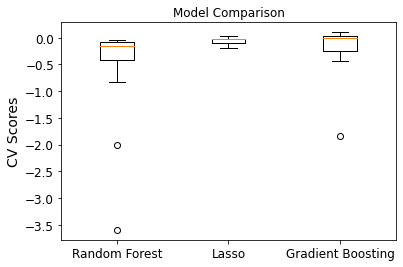

In [98]:
from sklearn.model_selection import cross_val_score

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=22)
    
 cv_results = cross_val_score(model, X, y, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Model Comparison')
plt.ylabel('CV Scores')
plt.show()

Since Lasso Regression has the highest score, it is chosen for further processing.

#### LassoCV Regression Model


6: -0.039439 (0.024390)
7: -0.039385 (0.024306)
8: -0.039382 (0.024301)
9: -0.031623 (0.028627)
10: -0.030976 (0.027426)
11: -0.031340 (0.028044)
12: -0.030776 (0.025609)


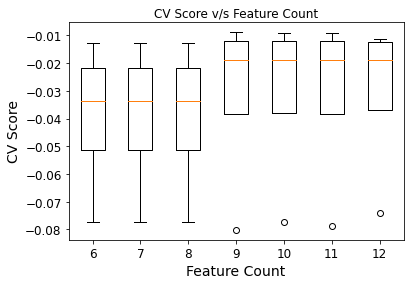

In [100]:
# Evaluate the model for different feature numbers
def evaluateLassoForFeatureNumber():
  results = []
  names = []

  featureCount = [6, 7, 8, 9, 10, 11, 12]

  for count in featureCount:
  
    pre_processor_pipeline = get_preprocessor_pipeline(count)
    lasso_pipeline = make_pipeline(pre_processor_pipeline, LassoCV())

        # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=4)
        
    cv_results = cross_val_score(lasso_pipeline, X, y, cv=tscv, scoring='r2')
    results.append(cv_results)
    print('%s: %f (%f)' % (count, cv_results.mean(), cv_results.std()))
      
  # Compare Algorithms
  plt.boxplot(results, labels=featureCount)
  plt.title('CV Score v/s Feature Count')
  plt.ylabel('CV Score')
  plt.xlabel('Feature Count')
  plt.show()

evaluateLassoForFeatureNumber()

10 Features give a good CV score.

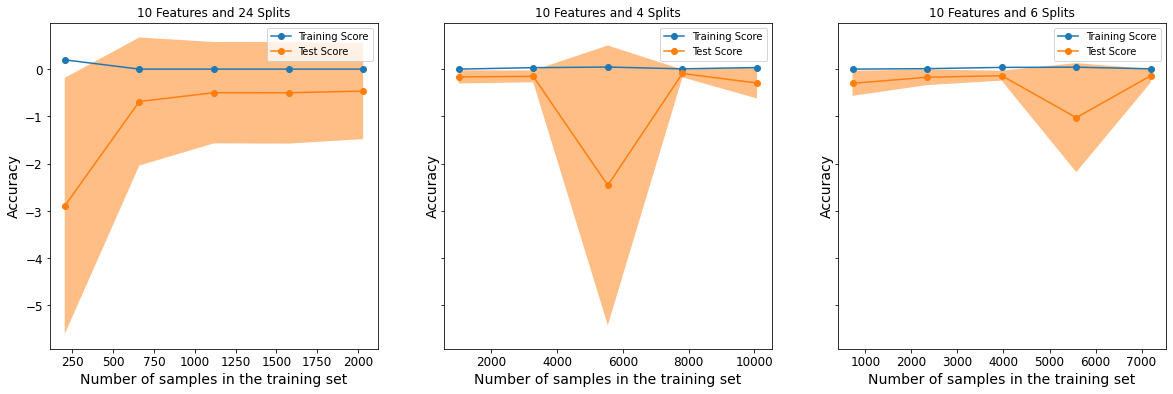

In [107]:
# DEV TEST: Learning curve 

from sklearn.model_selection import LearningCurveDisplay

def plotLearningCurve():
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharey=True)

  splits = [24, 4, 6]

  featureCount = 10
  preprocessor_pipeline = get_preprocessor_pipeline(featureCount)
  model = make_pipeline(preprocessor_pipeline, LassoCV())

  for ax_idx, split in enumerate(splits):
    common_params = {
        "X": X,
        "y": y,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": TimeSeriesSplit(n_splits=split),
        "score_type": "both",
        "n_jobs": 4,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "Accuracy",
    }

    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"{featureCount} Features and {split} Splits")

plotLearningCurve()

A good learning curve is obtained for split = 24

In [ ]:
# import time
# from sklearn.metrics import PredictionErrorDisplay
# from sklearn.model_selection import cross_validate, cross_val_predict

# fig, axs = plt.subplots(2, 2, figsize=(9, 7))
# axs = np.ravel(axs)

# for ax, (name, est) in zip(axs, estimators):
#     scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

#     start_time = time.time()
#     scores = cross_validate(
#         est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
#     )
#     elapsed_time = time.time() - start_time

#     y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
#     scores = {
#         key: (
#             f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
#             f"{np.std(scores[f'test_{value}']):.2f}"
#         )
#         for key, value in scorers.items()
#     }

#     display = PredictionErrorDisplay.from_predictions(
#         y_true=y,
#         y_pred=y_pred,
#         kind="actual_vs_predicted",
#         ax=ax,
#         scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
#         line_kwargs={"color": "tab:red"},
#     )
#     ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

#     for name, score in scores.items():
#         ax.plot([], [], " ", label=f"{name}: {score}")
#     ax.legend(loc="upper left")

# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.show()

## Classification Models

#### Classification Labels

,use [kW]
count,50391.000000
mean,0.860497
std,1.058185
min,0.000033
25%,0.369517
50%,0.563933
75%,0.973758
max,12.819183


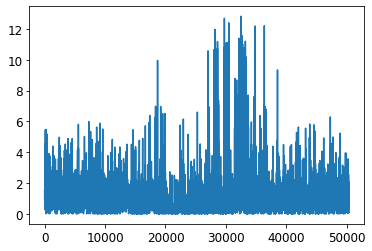

In [163]:
plt.plot(energy_usage['use [kW]'])
y_ = pd.DataFrame(energy_usage['use [kW]'])
y_.describe()


Since the max of the labels is 12.81, the series can be split into 3 classes as follows:

    y < 4 : LOW 
    4 < y < 8 : MEDIUM 
    8 < y : HIGH 

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_base.py:350: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


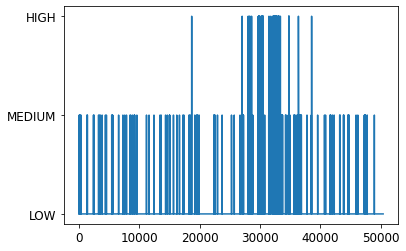

In [134]:
y = pd.cut(energy_usage['use [kW]'],
          bins=[0, 4, 8, np.inf],
          labels=['LOW', 'MEDIUM', 'HIGH'])
plt.plot(y)

#### Test Train Split

Split the data 70:30 train-test ratio.

In [164]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = False, stratify=None)

#### Helpers

In [ ]:
def plotLearningCurve(estimator, n_splits):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

  common_params = {
      "X": X_train,
      "y": y_train,
      "train_sizes": np.linspace(0.1, 1.0, 5),
      "cv": TimeSeriesSplit(n_splits=n_splits),
      "score_type": "both",
      "n_jobs": 4,
      "line_kw": {"marker": "o"},
      "std_display_style": "fill_between",
      "score_name": "Accuracy",
  }

  LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
  handles, label = ax.get_legend_handles_labels()
  ax.legend(handles[:2], ["Training Score", "Test Score"])
  ax.set_title(f"Training and Validation curve")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plotConfusionMatrix(y_test, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [284]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def showModelMetrics(y_test, y_pred):
  precision, recall, fs, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
  accuracy = accuracy_score(y_test, y_pred)

  print('precision : ', precision, '\nrecall : ', recall, '\nf1 score : ', fs, '\naccuracy : ', accuracy)

  print('For Latex table:', '&', "%.4f" % precision, '&', "%.4f" % recall, '&', "%.4f" % fs, '&', "%.4f" % accuracy, '\\')

#### MLP Classifier

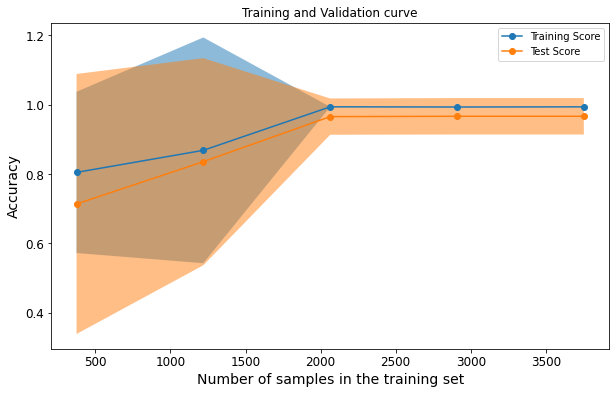

In [297]:
from sklearn.neural_network import MLPClassifier

mlp_c_pipeline = make_pipeline(preprocessor_pipeline, MLPClassifier(hidden_layer_sizes = [4,2]))
n_splits = 8

plotLearningCurve(mlp_c_pipeline, n_splits)

precision :  0.9720560795988095 
recall :  0.9859290438965724 
f1 score :  0.9789434145054321 
accuracy :  0.9859290438965724
For Latex table: & 0.9721 & 0.9859 & 0.9789 & 0.9859 \


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


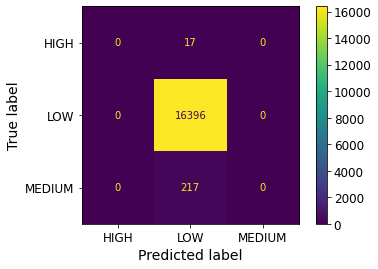

In [298]:
model = mlp_c_pipeline.fit(X_train, y_train,)
y_pred = model.predict(X_test)

plotConfusionMatrix(y_test, y_pred)
showModelMetrics(y_test, y_pred)

#### Random Forest Classifier

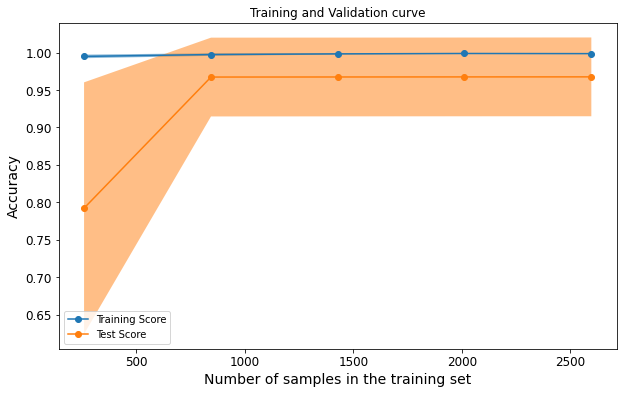

In [240]:
from sklearn.ensemble import RandomForestClassifier

rfc_pipeline = make_pipeline(preprocessor_pipeline, RandomForestClassifier(n_estimators=10, max_depth=20))
n_splits = 12

plotLearningCurve(rfc_pipeline, n_splits)

Fit and make predictions

In [ ]:
model = rfc_pipeline.fit(X_train, y_train)

#### Decision Tree Classifier

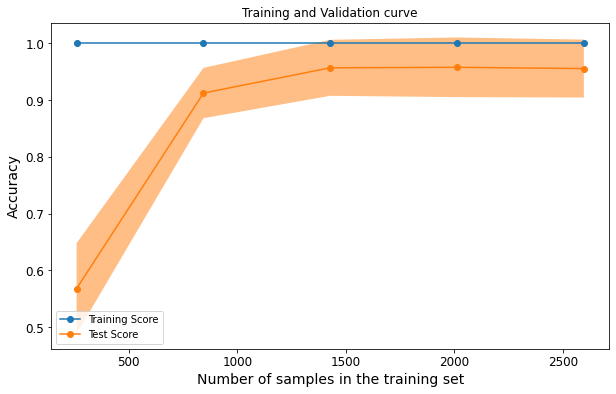

In [341]:
from sklearn.tree import DecisionTreeClassifier

tree_pipeline = make_pipeline(preprocessor_pipeline, DecisionTreeClassifier(max_depth=55))
n_splits = 12

plotLearningCurve(tree_pipeline, n_splits)

Fit and make predictions

precision :  0.9739215864893538 
recall :  0.8071557426337943 
f1 score :  0.8815300254132771 
accuracy :  0.8071557426337943
For Latex table: & 0.9739 & 0.8072 & 0.8815 & 0.8072 \


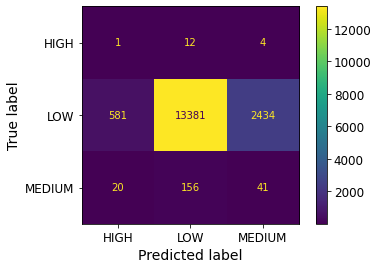

In [324]:
model = tree_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

plotConfusionMatrix(y_test, y_pred)
showModelMetrics(y_test, y_pred)

#### HistGradientBoostingClassifier

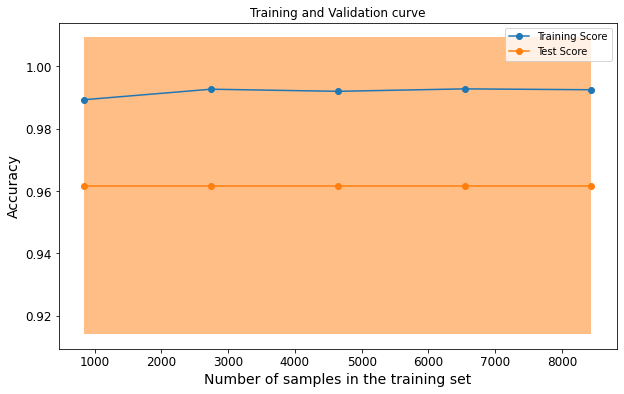

In [368]:
from sklearn.ensemble import HistGradientBoostingClassifier


hgbc_pipeline = make_pipeline(preprocessor_pipeline, HistGradientBoostingClassifier(max_depth=1))
n_splits = 3

plotLearningCurve(hgbc_pipeline, n_splits)


precision :  0.9720351928714718 
recall :  0.9844257366205652 
f1 score :  0.978191229213102 
accuracy :  0.9844257366205652
For Latex table: & 0.9720 & 0.9844 & 0.9782 & 0.9844 \


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


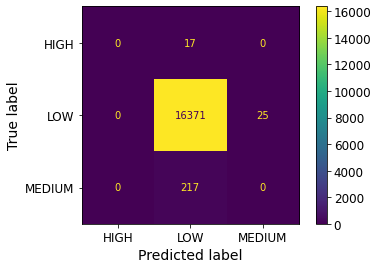

In [367]:
model = hgbc_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

plotConfusionMatrix(y_test, y_pred)
showModelMetrics(y_test, y_pred)

#### Extra Tree Classifier

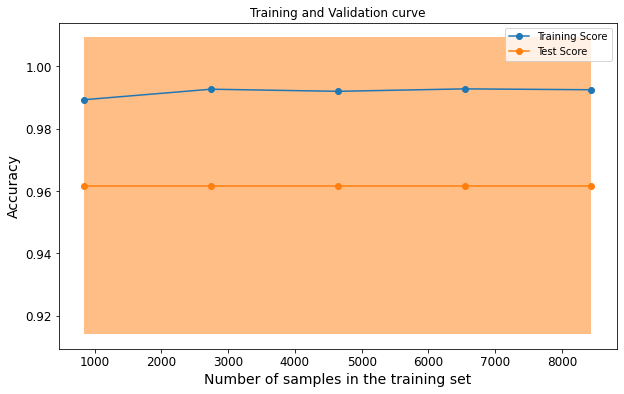

In [373]:
from sklearn.tree import ExtraTreeClassifier


et_pipeline = make_pipeline(preprocessor_pipeline, ExtraTreeClassifier(max_depth=1))
n_splits = 3

plotLearningCurve(et_pipeline, n_splits)

precision :  0.9720560795988095 
recall :  0.9859290438965724 
f1 score :  0.9789434145054321 
accuracy :  0.9859290438965724
For Latex table: & 0.9721 & 0.9859 & 0.9789 & 0.9859 \


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


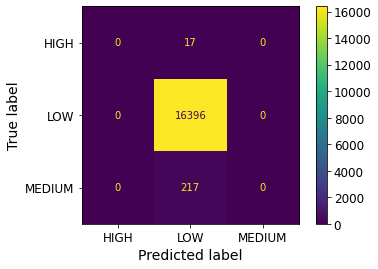

In [374]:
model = et_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

plotConfusionMatrix(y_test, y_pred)
showModelMetrics(y_test, y_pred)